<a href="https://colab.research.google.com/github/krishchopra02/LanguageTranslation/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import collections
import math
import tensorflow as tf
import matplotlib.pyplot as plt

from d2l import tensorflow as d2l

In [3]:
class Encoder(tf.keras.layers.Layer):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def call(self, X, *args, **kwargs):
        raise NotImplementedError


In [4]:
class Decoder(tf.keras.layers.Layer):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def call(self, X, state, **kwargs):
        raise NotImplementedError

In [5]:
class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super().__init__(*kwargs)
        # Embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)

    def call(self, X, *args, **kwargs):
        # The input `X` shape: (`batch_size`, `num_steps`)
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        output = self.rnn(X, **kwargs)
        state = output[1:]
        return output[0], state

In [6]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
X = tf.zeros((4, 7))
output, state = encoder(X, training=False)
output.shape

TensorShape([4, 7, 16])

In [7]:
class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_size)
        self.rnn = tf.keras.layers.RNN(tf.keras.layers.StackedRNNCells(
            [tf.keras.layers.GRUCell(num_hiddens, dropout=dropout)
             for _ in range(num_layers)]), return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def call(self, X, state, **kwargs):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = tf.repeat(tf.expand_dims(state[-1], axis=1), repeats=X.shape[1], axis=1)
        X_and_context = tf.concat((X, context), axis=2)
        rnn_output = self.rnn(X_and_context, state, **kwargs)
        output = self.dense(rnn_output[0])
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` is a list with `num_layers` entries. Each entry has shape:
        # (`batch_size`, `num_hiddens`)
        return output, rnn_output[1:]


In [8]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state, training=False)
output.shape, len(state), state[0].shape

(TensorShape([4, 7, 10]), 2, TensorShape([4, 16]))

In [9]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = tf.range(start=0, limit=maxlen, dtype=tf.float32)[
        None, :] < tf.cast(valid_len[:, None], dtype=tf.float32)

    if len(X.shape) == 3:
        return tf.where(tf.expand_dims(mask, axis=-1), X, value)
    else:
        return tf.where(mask, X, value)

X = tf.constant([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, tf.constant([1, 2]))


<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 0, 0],
       [4, 5, 0]], dtype=int32)>

In [10]:
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """The softmax cross-entropy loss with masks."""
    def __init__(self, valid_len):
        super().__init__(reduction='none')
        self.valid_len = valid_len

    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def call(self, label, pred):
        weights = tf.ones_like(label, dtype=tf.float32)
        weights = sequence_mask(weights, self.valid_len)
        label_one_hot = tf.one_hot(label, depth=pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none')(label_one_hot, pred)
        weighted_loss = tf.reduce_mean((unweighted_loss*weights), axis=1)
        return weighted_loss


In [11]:
def grad_clipping(grads, theta):
    """Clip the gradient."""
    theta = tf.constant(theta, dtype=tf.float32)
    new_grad = []
    for grad in grads:
        if isinstance(grad, tf.IndexedSlices):
            new_grad.append(tf.convert_to_tensor(grad))
        else:
            new_grad.append(grad)
    norm = tf.math.sqrt(sum((tf.reduce_sum(grad ** 2)).numpy()
                        for grad in new_grad))
    norm = tf.cast(norm, tf.float32)
    if tf.greater(norm, theta):
        for i, grad in enumerate(new_grad):
            new_grad[i] = grad * theta / norm
    else:
        new_grad = new_grad
    return new_grad


In [12]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [13]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

In [14]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [15]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


In [16]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    animator = d2l.Animator(xlabel="epoch", ylabel="loss",
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            X, X_valid_len, Y, Y_valid_len = [x for x in batch]
            bos = tf.reshape(tf.constant([tgt_vocab['<bos>']] * Y.shape[0]),
                             shape=(-1, 1))
            dec_input = tf.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            with tf.GradientTape() as tape:
                Y_hat, _ = net(X, dec_input, X_valid_len, training=True)
                l = MaskedSoftmaxCELoss(Y_valid_len)(Y, Y_hat)
            gradients = tape.gradient(l, net.trainable_variables)
            gradients = grad_clipping(gradients, 1)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            num_tokens = tf.reduce_sum(Y_valid_len).numpy()
            metric.add(tf.reduce_sum(l), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.034, 955.0 tokens/sec on <tensorflow.python.eager.context._EagerDeviceContext object at 0x7f4370981dc0>


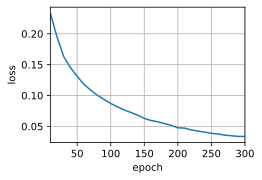

In [19]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()
import time
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)